# Generative Adversarial Networks (GANs)

The original paper : https://arxiv.org/abs/1406.2661

The purpose of the GANs is to generate new data instances. They learn the distribution of the training set and can generate new data never seen before. 

It consists of two neural networks: a generator and a discriminator. The generator creates fake data from random noise, while the discriminator evaluates whether the data is real or fake. 

During training, the generator aims to produce realistic data to fool the discriminator, and the discriminator learns to distinguish between real and fake data. This adversarial process continues until the generator produces data that the discriminator can no longer reliably identify as fake.

![Gan_image](https://media.licdn.com/dms/image/D5612AQHEdgJQaAOo8w/article-cover_image-shrink_600_2000/0/1684519028672?e=2147483647&v=beta&t=Zh3BO6wG6eYBfCoZzxnCdtvr9m0BXtQgQxyqq2LIrEY)

In [1]:
# we start importing some libraries
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam, RMSprop, SGD
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
import os
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
from tqdm import tqdm

# Set random seed for reproducibility
seed = 42

In [7]:
# Check if we have a GPU and if not use the CPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    
else:
    print("Please install GPU version of TF")
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Please install GPU version of TF


In [8]:
# we load the data, the fashion_mnist dataset, and we visualize some examples
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

# Expand the dimensions of the images to change the shape from (60000, 28, 28) to (60000, 28, 28, 1) and (10000, 28, 28) to (10000, 28, 28, 1)
X_train = expand_dims(X_train, axis=-1)
X_test = expand_dims(X_test, axis=-1)

print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Train: X=(60000, 28, 28, 1), y=(60000,)
Test: X=(10000, 28, 28, 1), y=(10000,)


In [9]:
# Check if the shape is correct, if not raise an error
assert X_train.shape == (60000, 28, 28, 1) and X_test.shape == (10000, 28, 28, 1), f"Expected (60000, 28, 28, 1) and (10000, 28, 28, 1) but got {X_train.shape} and {X_test.shape} respectively"

In [10]:
# Show the max value and min value of the images to understand the range of the pixel values

print(f"Max value: {X_train.max()}")
print(f"Min value: {X_train.min()}")
print(f"Reange of pixel values: {X_train.max() - X_train.min()}")

Max value: 255
Min value: 0
Reange of pixel values: 255


In [32]:
# The generator is using tanh activation in the last layer, because of that we need to preprocess
# the image data into a range between -1 and 1.

X_train = np.float32(X_train)

# Normalize X_train to range [-1, 1]
X_train_min = X_train.min()
X_train_max = X_train.max()
X_train = 2 * ((X_train - X_train_min) / (X_train_max - X_train_min)) - 1

#  Preprocess the test set in the same way as the train set
X_test = np.float32(X_test)
X_test_min = X_test.min()
X_test_max = X_test.max()
X_test = 2 * ((X_test - X_test_min) / (X_test_max - X_test_min)) - 1

In [33]:
# Check if the data is in the correct range, if not raise an error
assert X_train.min() >= -1 and X_train.max() <= 1, f"X train is in the range [{X_train.min()}, {X_train.max()}]"
assert X_test.min() >= -1 and X_test.max() <= 1, f"X test is in the range [{X_test.min()}, {X_test.max()}]"

In [34]:
# Show the max value and min value of the images to understand the range of the pixel values

print(f"Max value: {X_train.max()}")
print(f"Min value: {X_train.min()}")
print(f"Reange of pixel values: {X_train.max() - X_train.min()}")

Max value: 1.0
Min value: -1.0
Reange of pixel values: 2.0


In [35]:
# Show the max value and min value of the images to understand the range of the pixel values

print(f"Max value: {X_test.max()}")
print(f"Min value: {X_test.min()}")
print(f"Reange of pixel values: {X_test.max() - X_test.min()}")

Max value: 1.0
Min value: -1.0
Reange of pixel values: 2.0


In [36]:
def plot_real_samples(num_samples,title=""):
    fig=plt.figure(figsize=(7,7))

    for k in range(num_samples):
        plt.subplot(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), k + 1, xticks=[], yticks=[])
        aux = np.squeeze(X_train[k])
        plt.imshow(((aux + 1)* 127).astype(np.uint8),cmap='gray')

    fig.suptitle(title)
    plt.show()

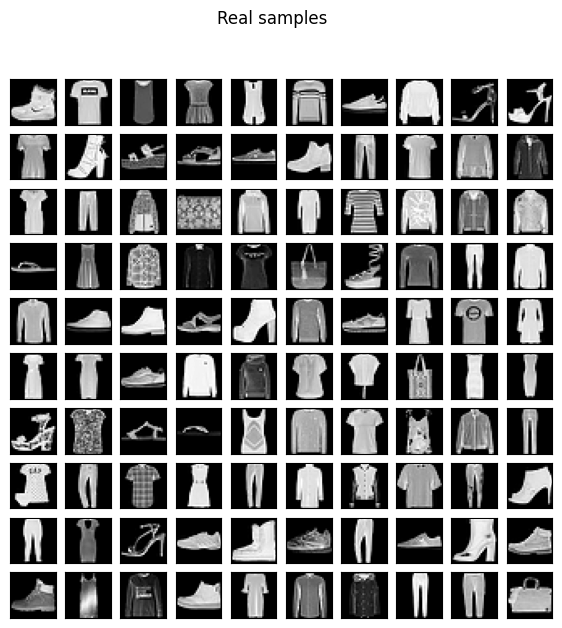

In [37]:
#we visualize some data
plot_real_samples(100, "Real samples")

### Main steps of the GAN

In [38]:
# A function to generate random inputs
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [39]:
# A function to sample a training point
def sample_real_data(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples)
    X = X_train[ix]
    y = ones((n_samples, 1))
    return X, y

In [40]:
# A function to generate a fake input from a random point
def generate_fake_samples(generator, latent_dim, n_samples):
    z_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict(z_input, verbose=0)
    y = zeros((n_samples, 1))
    return images, y

In [41]:
def save_model(iteration, g_model, latent_dim, is_conv=False):
    if is_conv==False:
        directory = f"models_with_latent_dim_{latent_dim}"
    else:
        directory = f"conv_models_with_latent_dim_{latent_dim}"

    if not os.path.exists(directory):
        os.makedirs(directory)

    filename = os.path.join(directory, f'model_{iteration:04d}.h5')
    g_model.save(filename)
    print('>Saved: %s' % (filename))

In [42]:
# As suggested by paper's authors, weights should be initialized
# with a Normal Distribution with standard deviation = 0.02
initializer = RandomNormal(stddev=0.02, seed=seed)

In [43]:
# Descriminator definition

# define the structure of the discriminator (binary classifier real-fake)
def define_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()

    model.add(Flatten(input_shape=in_shape))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid')) 
    
    # compile model with the Adam optimizer with a learning rate of 0.0002
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [44]:
# build the discriminator
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1024)              803840    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [45]:
# Set the latent space dimension (try with different values, e.g. 5, and see what happens)
latent_dim = 100

In [46]:
# define the generator
def define_generator(latent_dim):
    model = Sequential()
    
    model.add(Dense(256, kernel_initializer=initializer, input_shape=(latent_dim,)))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(512, kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(1024, kernel_initializer=initializer))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(28 * 28 * 1, kernel_initializer=initializer))
    
    # adding a tanh activation function
    model.add(Activation('tanh'))
    model.add(Reshape((28, 28, 1)))
    
    return model

In [47]:
# build the generator
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 784)              

In [48]:
# define the GANs architecture
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [49]:
gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0     

In [50]:
# Loss and Accuracy plots
def plot_loss_and_acc(d_loss, g_loss, d_acc, dim=(12,4), is_conv=False):
    plt.figure(figsize=dim)
    plt.subplot(1, 2, 1)  # Create the first subplot for loss
    plt.plot(d_loss, label='Discriminator')
    plt.plot(g_loss, label='Generator')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)  # Create the second subplot for accuracy
    plt.plot(d_acc, label='Discriminator')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('loss_acc_plot.png') if is_conv==False else plt.savefig('conv_loss_acc_plot.png')
    plt.show()
    plt.close()
    
# using the function predict() generate num_samples samples and plot it using plt.imshow
def plot_generated_samples(generator,num_samples,title=""):
    x_fake = generator.predict(generate_latent_points(latent_dim, num_samples))
    fig = plt.figure(figsize=(7,7))
    for k in range(num_samples):
        plt.subplot(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), k + 1, xticks=[], yticks=[])
        aux = np.squeeze(x_fake[k])
        plt.imshow(((aux + 1)* 127).astype(np.uint8), cmap='gray')
    fig.suptitle(title)
    plt.show()

**Train the GAN model**

In order to train the model, we can use the train_on_batch function provides by Keras (https://keras.io/api/models/model_training_apis/#trainonbatch-method)

In [54]:
# Training function
def train(g_model, d_model, gan_model, X_train, latent_dim, iterations=1400, batch_size=128, is_conv=False):

    print(f"---- Starting the training for {iterations} training iterations ---\n")
    # Initialize lists to store the loss and accuracy values
    d_loss_vec = []
    g_loss_vec = []
    d_acc_vec = []
    g_acc_vec = []
    # Iterate over the total number of training steps
    for i in tqdm(range(iterations)):

        # Sample real data and generate fake data
        X_real, y_real = sample_real_data(X_train, batch_size)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, batch_size)

        # Train the discriminator on real data / fake data and record the loss and accuracy
        d_loss_r, d_acc_r = d_model.train_on_batch(X_real, y_real)
        d_loss_f, d_acc_f = d_model.train_on_batch(X_fake, y_fake) 

        # Calculate the discriminator loss and accuracy for the batch
        d_loss_batch = d_loss_r + d_loss_f
        d_acc_batch = 0.5 * (d_acc_r + d_acc_f)

        # Generate latent points as input for the generator
        # Use the generate_latent_points function to generate latent points
        z_input =  generate_latent_points(latent_dim, batch_size)

        # Create labels for the generator (all ones to indicate fake images as real)
        y_gan = np.ones((batch_size, 1))

        # Train the generator via the combined GAN model and record the loss
        g_loss, g_acc = gan_model.train_on_batch(z_input, y_gan)

        # Append the generator and discriminator loss for the batch
        d_loss_vec.append(d_loss_batch)
        d_acc_vec.append(d_acc_batch)
        g_loss_vec.append(g_loss)
        g_acc_vec.append(g_acc)

        # Every 1000 steps, summarize performance, display generated samples and plot the metrics
        if (i+1) % 1000 == 0:
            plot_generated_samples(g_model,36)
            plot_loss_and_acc(d_loss_vec, g_loss_vec, d_acc_vec, is_conv=is_conv)
            save_model(i+1, g_model, latent_dim, is_conv=is_conv)
            print(f"Iteration {i+1}/{iterations} - Discriminator Loss: {d_loss_batch:.4f}, Generator Loss: {g_loss:.4f} - Discriminator Accuracy: {d_acc_batch:.4f}")

---- Starting the training for 10000 training iterations ---



 10%|▉         | 999/10000 [02:31<23:06,  6.49it/s]

2/2 [==============================] - 0s 4ms/step


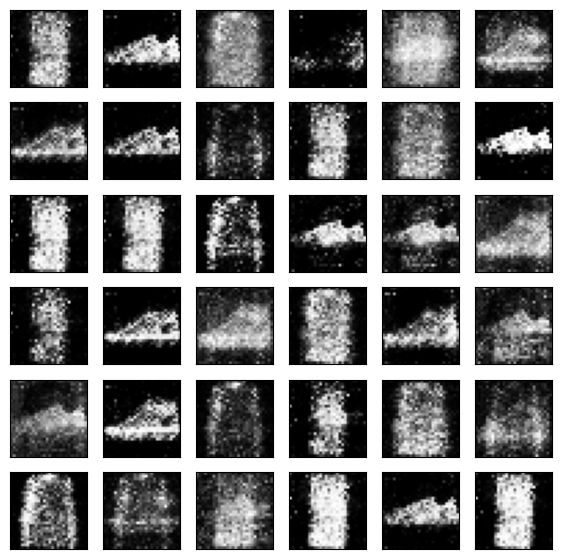

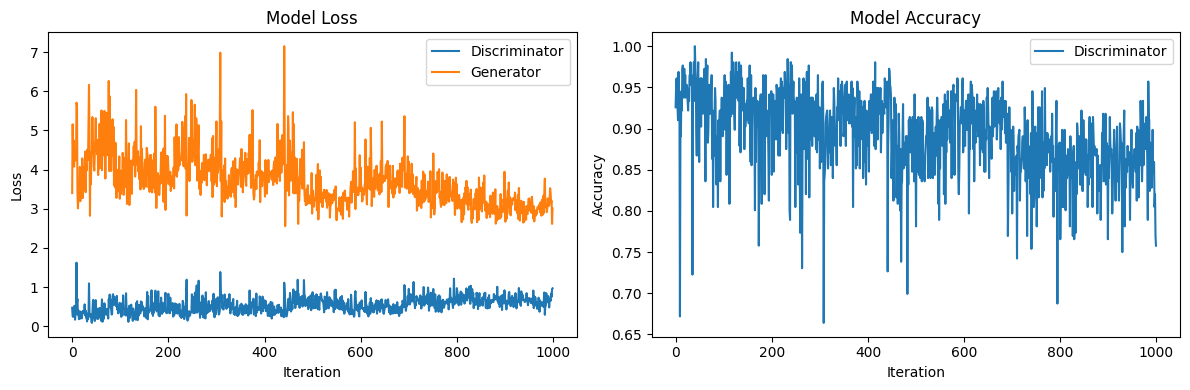

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 10%|█         | 1000/10000 [02:32<1:30:38,  1.65it/s]

>Saved: models_with_latent_dim_100\model_1000.h5
Iteration 1000/10000 - Discriminator Loss: 0.9704, Generator Loss: 3.0054 - Discriminator Accuracy: 0.7578


 20%|█▉        | 1999/10000 [05:46<31:36,  4.22it/s]  

2/2 [==============================] - 0s 6ms/step


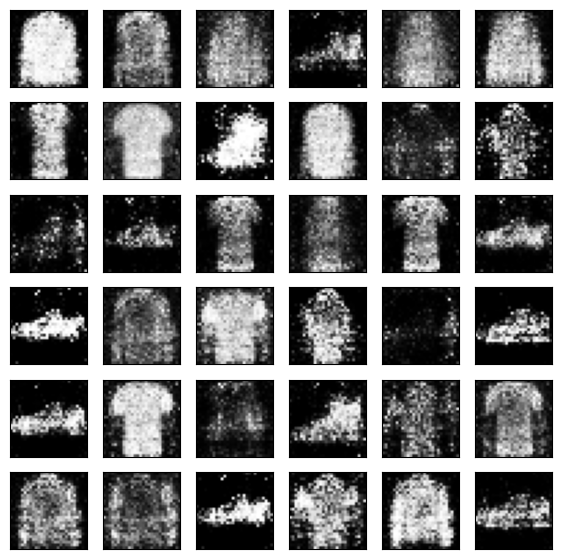

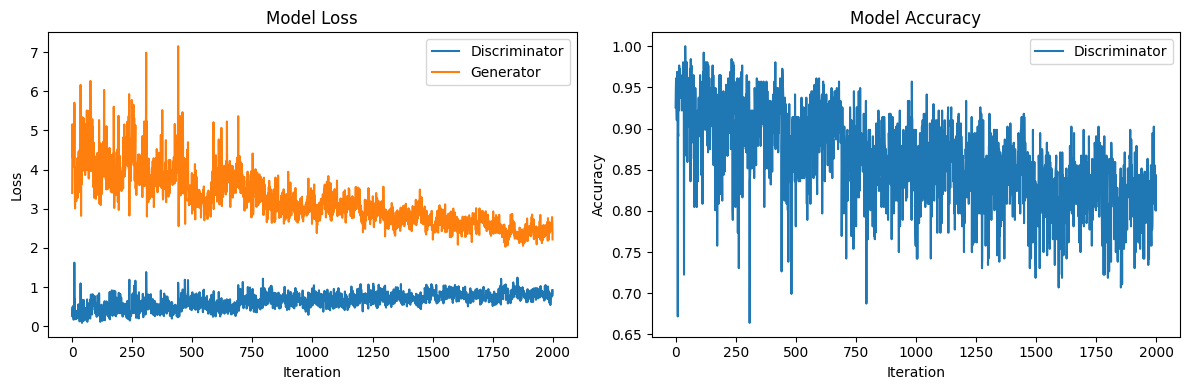

 20%|██        | 2000/10000 [05:48<1:43:13,  1.29it/s]

>Saved: models_with_latent_dim_100\model_2000.h5
Iteration 2000/10000 - Discriminator Loss: 0.9257, Generator Loss: 2.2193 - Discriminator Accuracy: 0.8008


 30%|██▉       | 2999/10000 [09:52<29:56,  3.90it/s]  

2/2 [==============================] - 0s 7ms/step


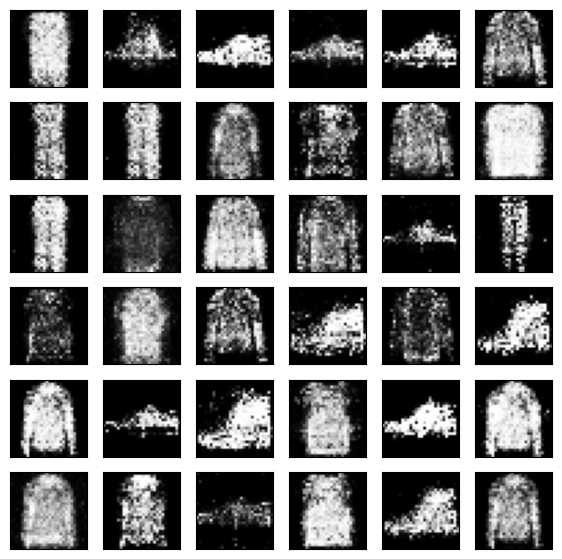

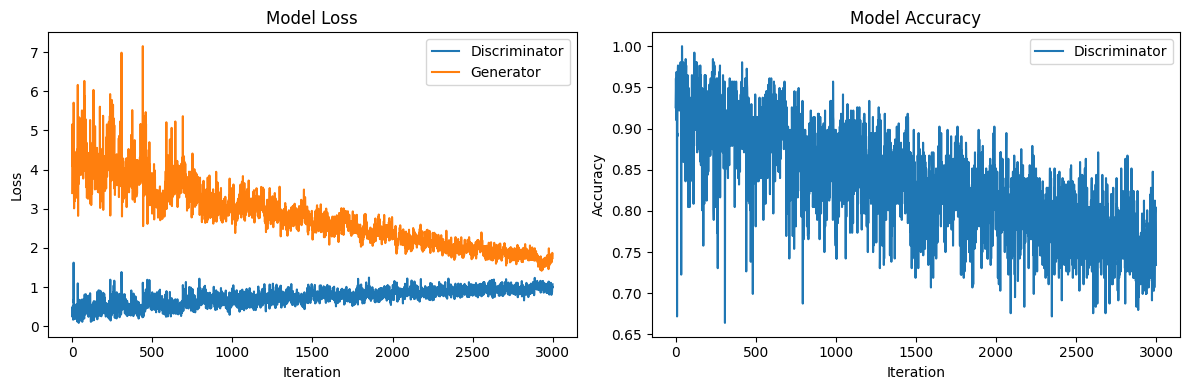

 30%|███       | 3000/10000 [09:53<1:19:28,  1.47it/s]

>Saved: models_with_latent_dim_100\model_3000.h5
Iteration 3000/10000 - Discriminator Loss: 1.0728, Generator Loss: 1.7415 - Discriminator Accuracy: 0.7344


 40%|███▉      | 3999/10000 [14:37<30:39,  3.26it/s]  

2/2 [==============================] - 0s 8ms/step


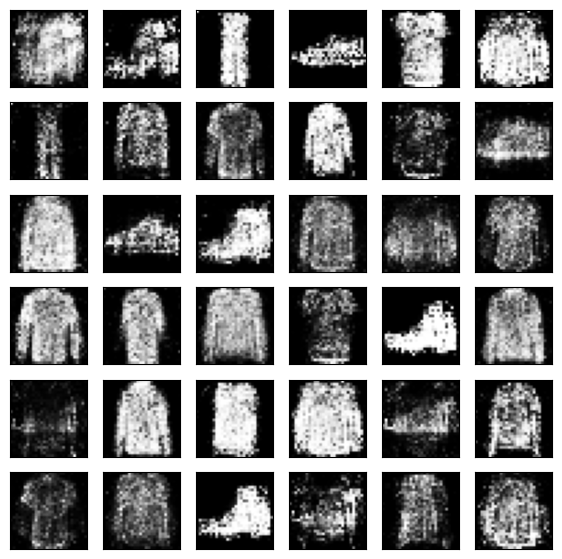

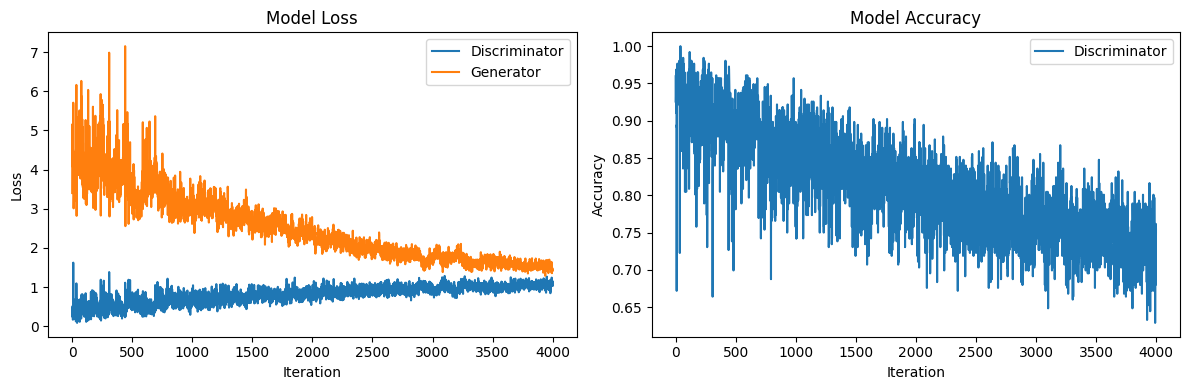

 40%|████      | 4000/10000 [14:39<1:23:39,  1.20it/s]

>Saved: models_with_latent_dim_100\model_4000.h5
Iteration 4000/10000 - Discriminator Loss: 1.0363, Generator Loss: 1.4191 - Discriminator Accuracy: 0.7539


 50%|████▉     | 4999/10000 [20:18<31:15,  2.67it/s]  

2/2 [==============================] - 0s 11ms/step


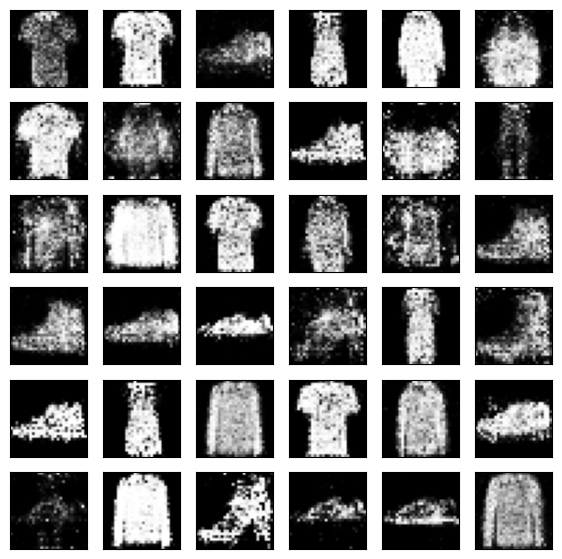

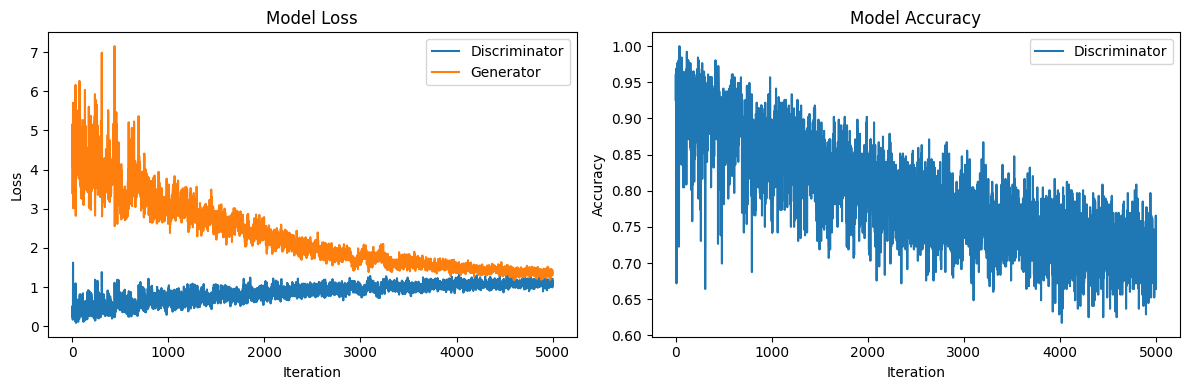

 50%|█████     | 5000/10000 [20:21<1:20:26,  1.04it/s]

>Saved: models_with_latent_dim_100\model_5000.h5
Iteration 5000/10000 - Discriminator Loss: 1.2090, Generator Loss: 1.3201 - Discriminator Accuracy: 0.6641


 60%|█████▉    | 5999/10000 [26:41<26:50,  2.48it/s]  

2/2 [==============================] - 0s 11ms/step


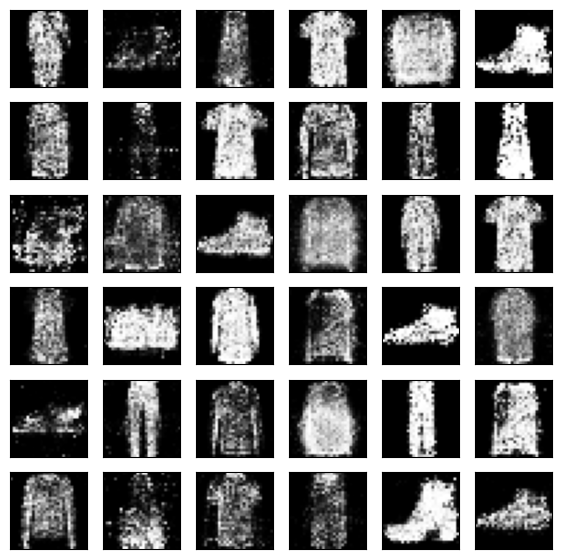

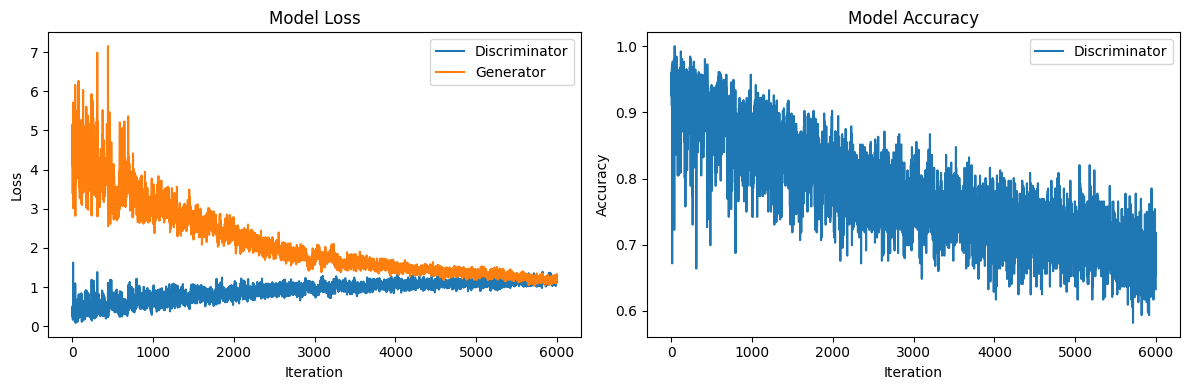

 60%|██████    | 6000/10000 [26:43<1:00:07,  1.11it/s]

>Saved: models_with_latent_dim_100\model_6000.h5
Iteration 6000/10000 - Discriminator Loss: 1.3199, Generator Loss: 1.1684 - Discriminator Accuracy: 0.6328


 70%|██████▉   | 6999/10000 [33:55<22:42,  2.20it/s]  

2/2 [==============================] - 0s 14ms/step


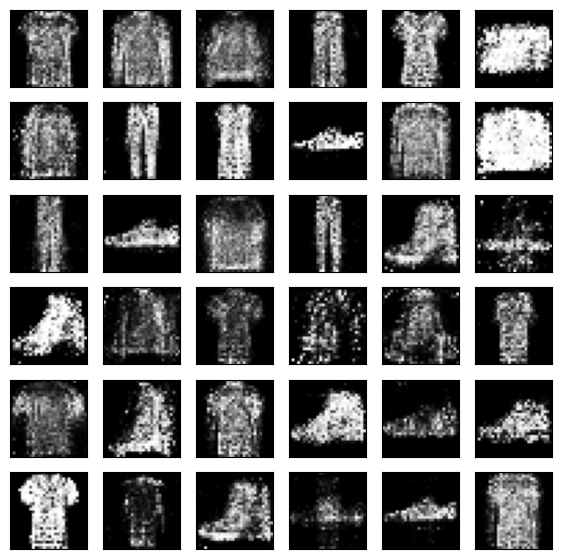

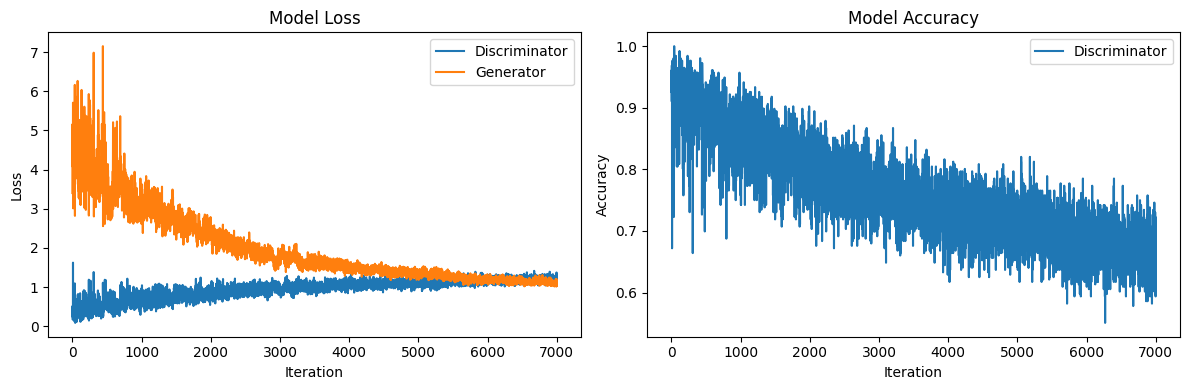

 70%|███████   | 7000/10000 [33:57<48:06,  1.04it/s]

>Saved: models_with_latent_dim_100\model_7000.h5
Iteration 7000/10000 - Discriminator Loss: 1.1980, Generator Loss: 1.0342 - Discriminator Accuracy: 0.7031


 80%|███████▉  | 7999/10000 [42:45<19:46,  1.69it/s]

2/2 [==============================] - 0s 15ms/step


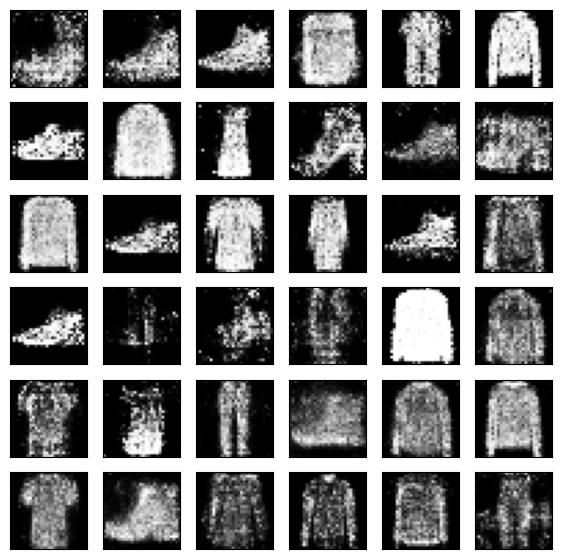

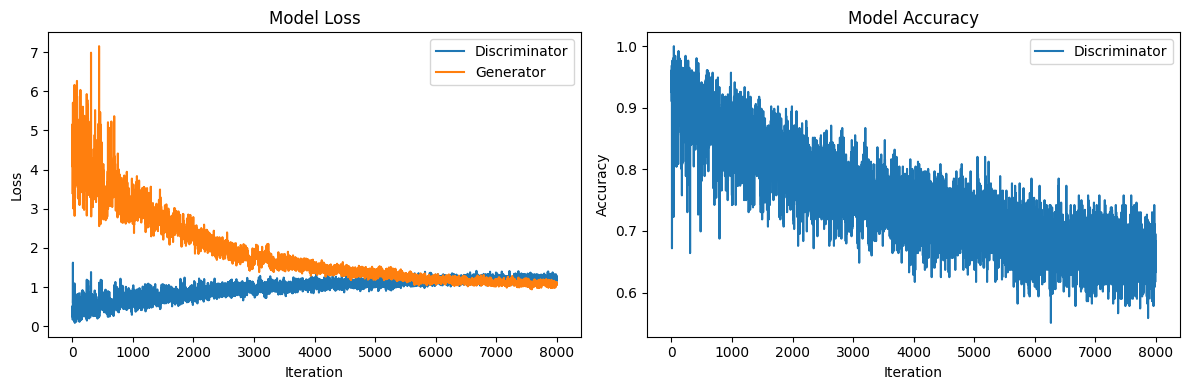

 80%|████████  | 8000/10000 [42:48<40:52,  1.23s/it]

>Saved: models_with_latent_dim_100\model_8000.h5
Iteration 8000/10000 - Discriminator Loss: 1.1920, Generator Loss: 1.0551 - Discriminator Accuracy: 0.6445


 90%|████████▉ | 8999/10000 [55:18<12:44,  1.31it/s]

2/2 [==============================] - 0s 20ms/step


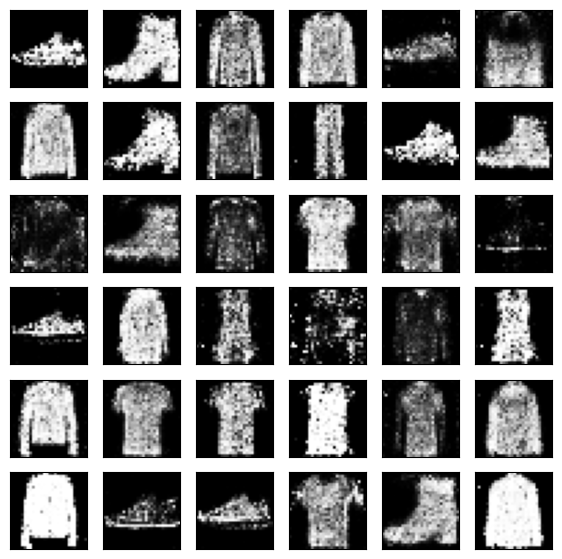

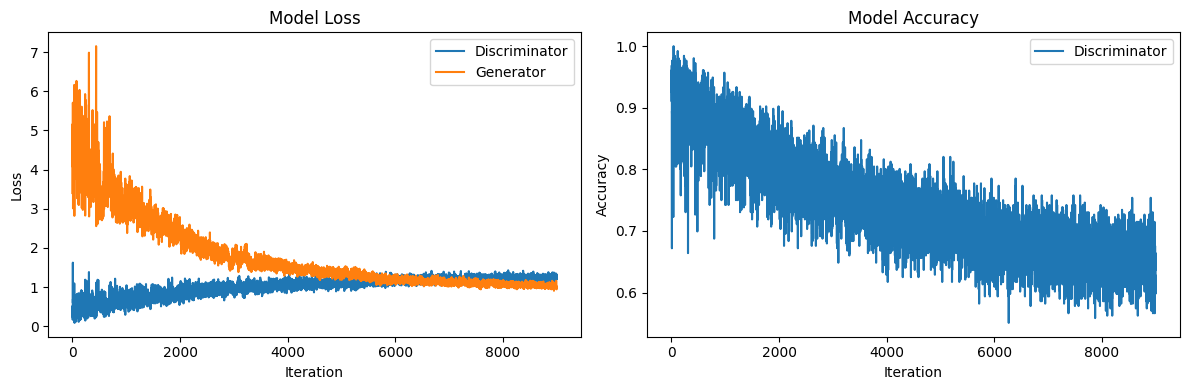

 90%|█████████ | 9000/10000 [55:21<24:25,  1.47s/it]

>Saved: models_with_latent_dim_100\model_9000.h5
Iteration 9000/10000 - Discriminator Loss: 1.2646, Generator Loss: 1.0122 - Discriminator Accuracy: 0.6445


100%|█████████▉| 9999/10000 [1:08:02<00:00,  1.37it/s]

2/2 [==============================] - 0s 24ms/step


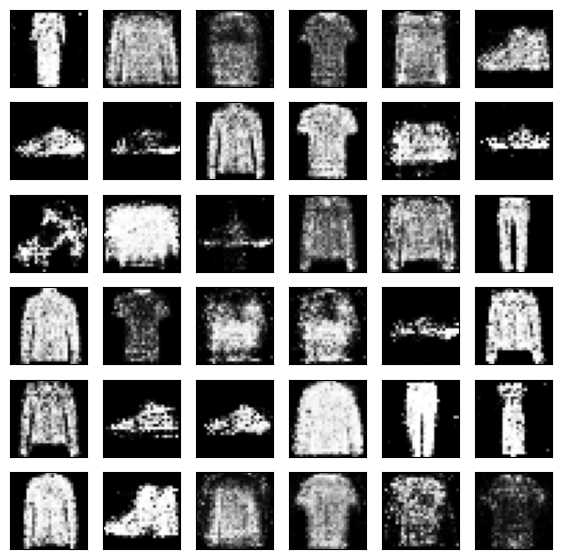

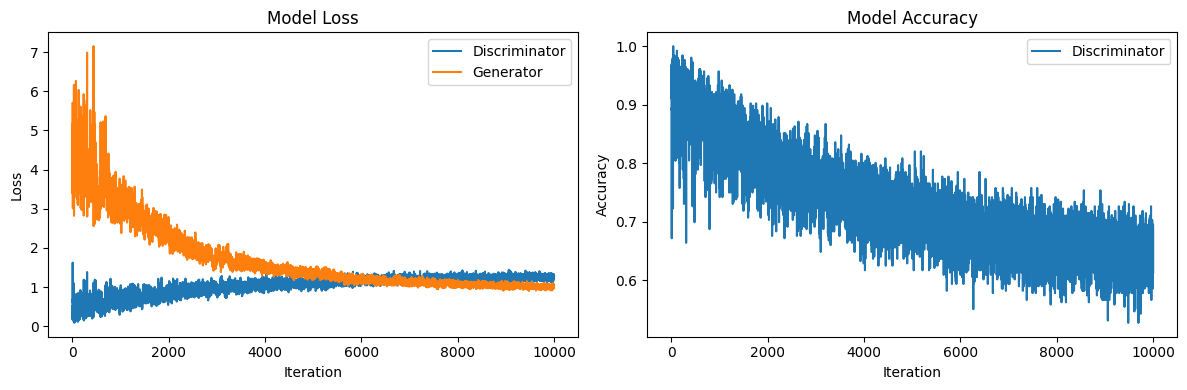

100%|██████████| 10000/10000 [1:08:05<00:00,  2.45it/s]

>Saved: models_with_latent_dim_100\model_10000.h5
Iteration 10000/10000 - Discriminator Loss: 1.2820, Generator Loss: 1.0423 - Discriminator Accuracy: 0.6133


In [55]:
train(generator, discriminator, gan_model, X_train, latent_dim, iterations=10000, batch_size=128, is_conv=False)

#### Load the trained model and display the results 
model_name = 
```
['model_1000.h5', 'model_2000.h5', 'model_3000.h5', ..., 'model_9000.h5', 'model_10000.h5']
```

Loaded the model: model_10000.h5 trained with a latent dim of 100
2/2 [==============================] - 0s 24ms/step


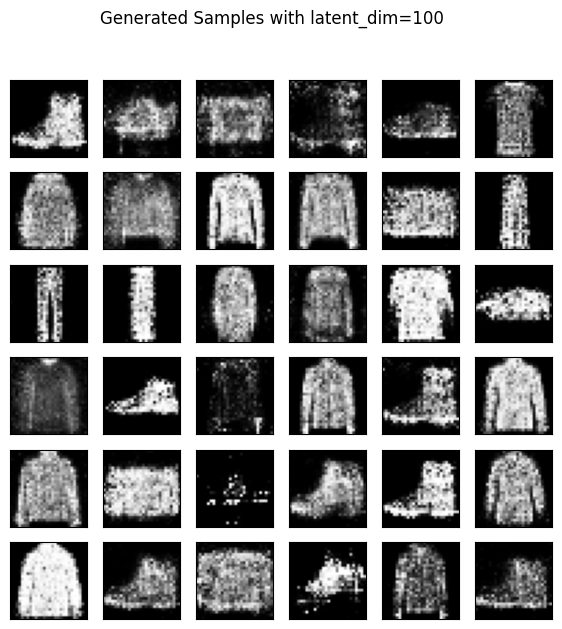

In [56]:
latent_dim = 100  # <-- PUT HERE THE LATENT DIMENSION OF YOUR TRAINED MODEL!!
model_name = "model_10000.h5" # <-- PUT HERE THE NAME OF YOUR TRAINED MODEL!!

# load one of the saved models
generator = load_model(f"models_with_latent_dim_{latent_dim}/{model_name}")
print(f"Loaded the model: {model_name} trained with a latent dim of {latent_dim}")

# display the generated samples
plot_generated_samples(generator, 36, title=f"Generated Samples with latent_dim={latent_dim}")

# DCGAN (Deep Convolution Generative Advesarial Network)

At https://arxiv.org/pdf/1511.06434.pdf you can find the Deep Convolutional Generative Adversarial Network (DCGAN) paper: this latter has lot of useful suggestions in terms of settings about the architecture, the optimizers and the hyperparameters to use.

**Define the Convolutional Generator**

The Generator takes as input random noise (low dimensionality, e.g. 100) and produce an image (high dimensionality, e.g. 28 x 28 x 3): in order to perform the upsampling operation we can use the transposed convolution (Conv2DTranspose in Keras).

The first layer of the Generator is a Dense layer that takes random noise as input (of dimension latent_dim) and upsample it through layers in order to obtain the size of the image (in this case 28x28x1).

After each Conv2DTranspose layer we add a BatchNormalization and a LeakyRelu activation layer. The output layer uses tanh activation in order to output an image in [-1,1]. 

For more see: https://www.tensorflow.org/tutorials/generative/dcgan

In [57]:
#Define a random initializer for the networks' weights
initializer = RandomNormal(stddev=0.02, seed=seed)

In [58]:
# Define the latent space dimension
latent_dim = 100

In [69]:
def define_conv_generator(latent_dim):
    
    # 7x7x256
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    # 14x14x128
    model.add(Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same'))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # 14x14x64
    model.add(Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))  # Questa è la riga corretta
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())


    # 28x28x1
    model.add(Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [70]:
conv_generator = define_conv_generator(latent_dim)
conv_generator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_10 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 7, 7, 128)         819328    
 Transpose)                                                      
                                                                 
 batch_normalization_11 (Ba  (None, 7, 7, 128)        

1/1 [==============================] - 0s 475ms/step


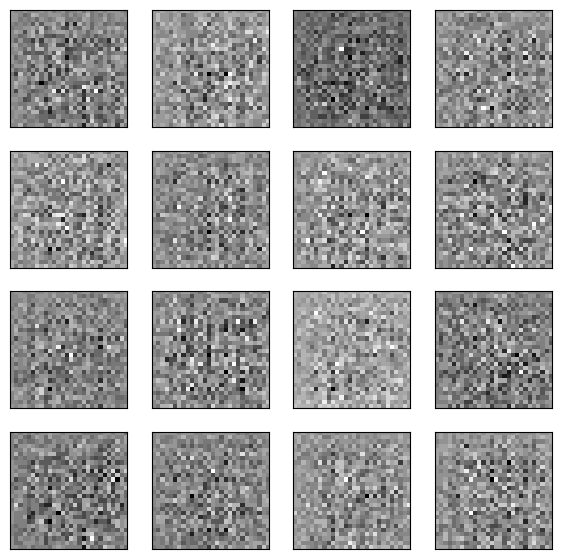

In [71]:
plot_generated_samples(conv_generator,16)

The Discriminator is a CNN. It is a binary classification problem.

In [72]:
def define_conv_discriminator(in_shape=(28, 28, 1)):
    
    # 14x14x64
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # 7x7x128
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    # Flatten layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with the Adam optimizer
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
     
    return model

In [73]:
input_shape = X_train.shape[1:]
print(input_shape)

conv_discriminator = define_conv_discriminator(input_shape)
conv_discriminator.summary()

(28, 28, 1)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272) 

**Define the DCGAN model**

In order to create the DCGAN model in Keras you should create a Model that incorporate both the Generator and the Discriminator.

In [74]:
# define the GANs architecture
def define_gan(g_model, d_model):
    d_model.trainable = False
    gan_output = d_model(g_model.output)
    model = Model(g_model.input, gan_output)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [75]:
dcgan_model = define_gan(conv_generator, conv_discriminator)
dcgan_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13_input (InputLayer  [(None, 100)]             0         
 )                                                               
                                                                 
 dense_13 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_10 (Ba  (None, 12544)             50176     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 7, 7, 128)         8193

---- Starting the training for 10000 training iterations ---



 10%|▉         | 999/10000 [4:06:57<38:38:35, 15.46s/it]    

2/2 [==============================] - 1s 207ms/step


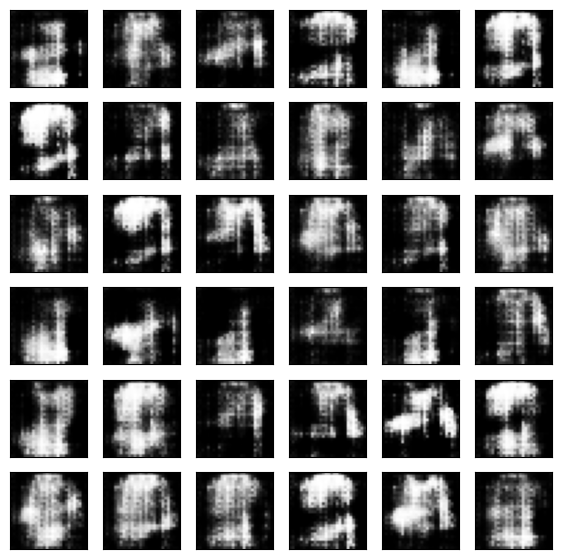

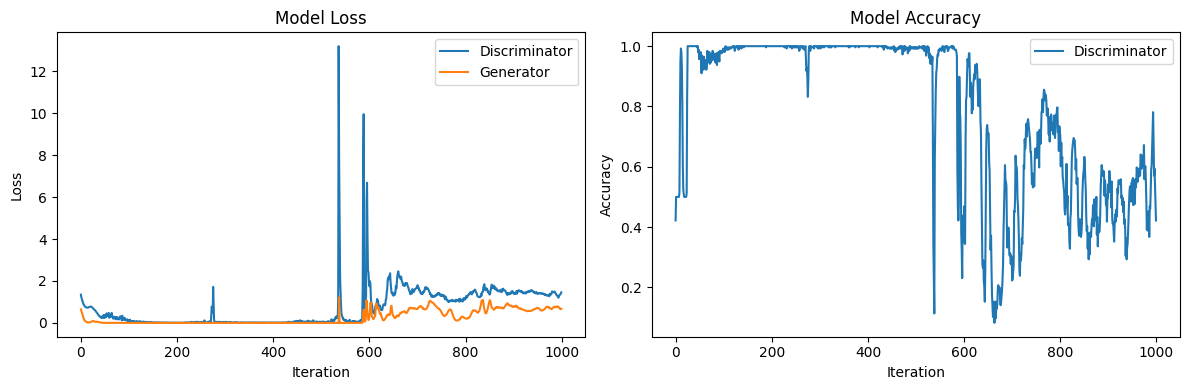

 10%|█         | 1000/10000 [4:07:16<41:45:31, 16.70s/it]

>Saved: conv_models_with_latent_dim_100\model_1000.h5
Iteration 1000/10000 - Discriminator Loss: 1.4541, Generator Loss: 0.6715 - Discriminator Accuracy: 0.4219


 11%|█▏        | 1143/10000 [4:36:14<35:40:37, 14.50s/it]


KeyboardInterrupt: 

In [76]:
train(conv_generator, conv_discriminator, dcgan_model, X_train, latent_dim, iterations=10000, batch_size=128, is_conv=True)

Loaded the model: model_10000.h5 trained with a latent dim of 100
2/2 [==============================] - 1s 74ms/step


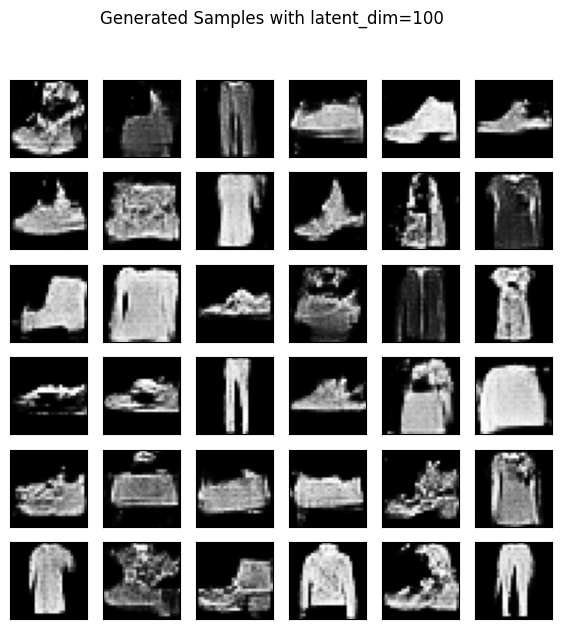

In [80]:
latent_dim = 100  # <-- PUT HERE THE LATENT DIMENSION OF YOUR TRAINED MODEL!!
model_name = "model_10000.h5" # <-- PUT HERE THE NAME OF YOUR TRAINED MODEL!!
#conv_generator = load_model(f"conv_models_with_latent_dim_{latent_dim}/{model_name}")

# define the path where the models are saved
model_path = r"C:\Users\ACER\Desktop\DLCV_2024\DLCV2024_for_students\labs\LAB05_GAN\GANs_PreTrainedModels\conv_models_with_latent_dim_100"

# load one of the saved models
conv_generator = load_model(f"{model_path}/{model_name}")
print(f"Loaded the model: {model_name} trained with a latent dim of {latent_dim}")

# display the generated samples
plot_generated_samples(conv_generator, 36, title=f"Generated Samples with latent_dim={latent_dim}")

# Display the real and the GAN/DCGAN generated images

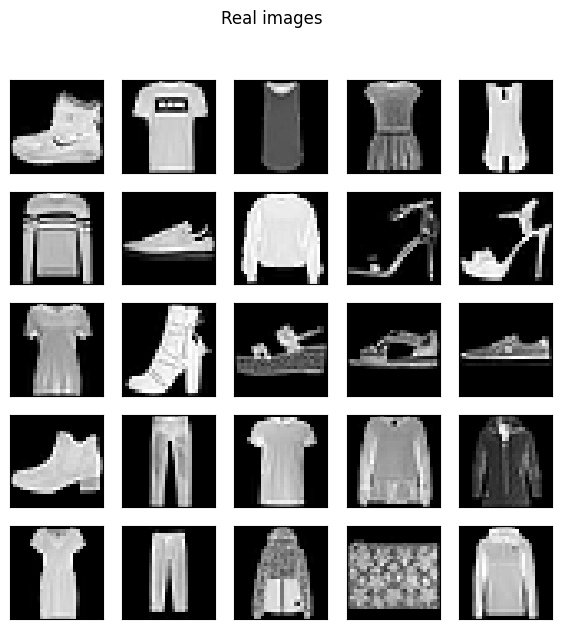

1/1 [==============================] - 0s 89ms/step


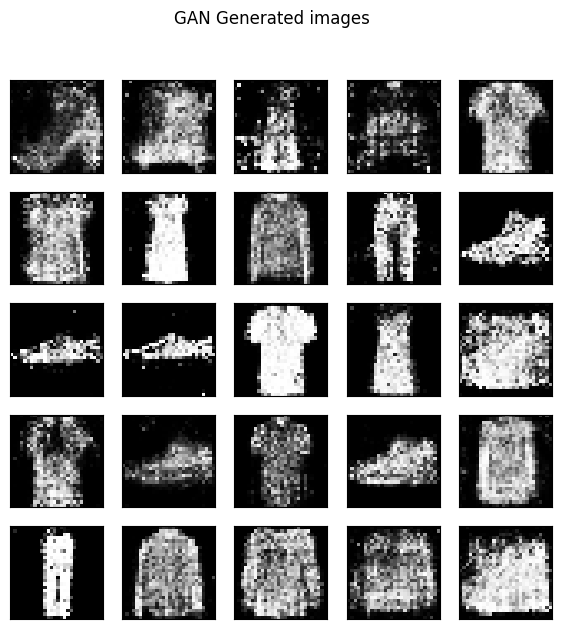

1/1 [==============================] - 0s 478ms/step


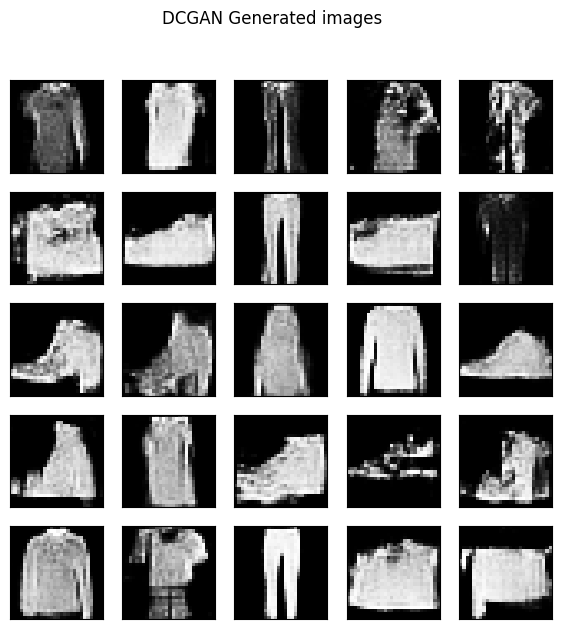

In [85]:
latent_dim = 100  # <-- PUT HERE THE LATENT DIMENSION OF YOUR TRAINED MODEL!!
model_name = "model_8000.h5" # <-- PUT HERE THE NAME OF YOUR TRAINED MODEL!!

generator = load_model(f"models_with_latent_dim_{latent_dim}/{model_name}")
conv_generator = load_model(f"conv_models_with_latent_dim_{latent_dim}/{model_name}")



plot_real_samples(25, "Real images")
plot_generated_samples(generator, 25, "GAN Generated images")
plot_generated_samples(conv_generator, 25, "DCGAN Generated images")